In [336]:
import glob
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import datetime
import dateutil.parser as parser
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# master dataframe
cdc_zika = pd.read_csv("cdc_zika.csv", usecols = ['report_date','location','data_field','value'])
cdc_zika.dropna(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# make cdcUSA
cdcUSA = cdc_zika[cdc_zika.location.str.contains('United_States-')]
# get rid of pesky Florida counties
cdcUSA = cdcUSA[(cdcUSA.data_field == 'zika_reported_travel') | 
                (cdcUSA.data_field == 'zika_reported_local')]
# combine travel and local cases
zika_counts = cdcUSA.groupby('location').sum().value

In [152]:
# temperature data
temp = pd.read_csv('usa_avg_summer_temp.csv', index_col='State')

In [5]:
### OAG flight stuff

oag = pd.read_csv('OAGJAN13.csv')

# take out relevant columns
oag_subset = oag[['depctry','arrctry','arrcity','days','efffrom','effto','seats','distance']]

# turn days into number of days
oag_subset.days = [len(x) for x in oag_subset.days]

# translate fromday (str) to number of days from beginning of 2016 (int)
# same for today
fromdays = np.array(map(lambda x: int(x[-2:]) + 30*(int(x[-4:-2])-1), oag_subset.efffrom.astype(str)))
todays = np.array(map(lambda x: int(x[-2:]) + 30*(int(x[-4:-2])-1),oag_subset.effto.astype(str)))

# only interested in first half of year (since only have Zika data for then)
todays[todays > 183] = [183]*len(todays[todays > 183]) # cannot end after June
oag_subset['fromdays'] = fromdays
oag_subset['todays'] = todays
oag_subset['flights'] = ((todays - fromdays)/7.0 * oag_subset['days'].astype(int)) # calculate flights
oag_subset = oag_subset.ix[oag_subset.fromdays < 183] # cannot start after June
# round to integer
oag_subset.flights = np.round(oag_subset.flights)

# remove unneeded columns 'effrom' 'effto' etc
oag_subset = oag_subset[['depctry','arrctry','arrcity','seats','distance','flights']]

# only interested in BR to US
oag_subset = oag_subset[(oag_subset.depctry == 'BR') & (oag_subset.arrctry == 'US')]

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (51,53,54,55,56,58,60,62,64,66,68,70,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [6]:
# calculate total_seats and flights for each route
oag_subset['total_seats_oag'] = oag_subset.seats * oag_subset.flights
total_seats_oag = oag_subset['total_seats_oag'].groupby(oag_subset.arrcity).sum()
flights_oag = oag_subset['flights'].groupby(oag_subset.arrcity).sum()

In [7]:
# consolidate
oag_data = pd.DataFrame([total_seats_oag,flights_oag]).T
# group by state instead of arrcity
state = ['Georgia','Illinois','North Carolina','Texas','Michigan','Texas','California','Florida','New York','Florida','California','Washington']
oag_data.index = state
oag_data = oag_data.groupby(oag_data.index).sum()
oag_data.columns = ['total_seats_oag','flights_oag']

In [8]:
### BTS data
bts_data = pd.read_csv('stateflightdata_jan_june.csv', index_col = 'State')
bts_data.drop('abr', axis=1, inplace=True)

In [106]:
### Population data
pop_data = pd.read_csv('state_populations.csv', index_col = 'State')
pop_data['pop'] = map(lambda x: int(x.replace(',','')), pop_data['pop']) # string to int

In [212]:
### input mosquito data from Russell
mosquito = pd.read_csv('mosquitodata.csv', index_col=0)

In [34]:
# reindex to get rid of 'United_States-' prefix
zika_counts.index = [x[len('United_States-'):] for x in zika_counts.index]
# reindex to get rid of 'Pennsylvania††'
zika_counts.Pennsylvania = zika_counts['Pennsylvania'] + zika_counts['Pennsylvania††']
zika_counts.drop('Pennsylvania††', inplace=True)
# write csv
zika_counts.to_csv('zika_counts.csv')

In [300]:
# manual editing in excel D:
#oag_data.to_csv('oag_data.csv')
#bts_data.to_csv('bts_data.csv')
oag_data = pd.read_csv('oag_data.csv',index_col='State')
bts_data = pd.read_csv('bts_data.csv',index_col='State')
pop_data = pd.read_csv('state_populations.csv',index_col='State')
pop_data['pop'] = map(lambda x: int(x.replace(',','')), pop_data['pop']) # string to int
temp = pd.read_csv('usa_avg_summer_temp.csv',index_col='State')
zika_counts = pd.read_csv('zika_counts.csv',index_col='State')

zika_counts.loc['Alaska'] = 0
zika_counts.loc['Idaho'] = 0
zika_counts.loc['North Dakota'] = 0
zika_counts.loc['South Dakota'] = 0
zika_counts.loc['Wyoming'] = 0

In [301]:
# make master dataframe
master = pd.DataFrame({})
master['zika_counts'] = zika_counts.zika_counts
master['temp'] = temp
master['pop_data'] = pop_data
master['mosquito'] = mosquito['Number of occurences (1960-2016)']
master['total_seats_oag'] = oag_data.total_seats_oag
master['flights_oag'] = oag_data.flights_oag
master['passengers_bts'] = bts_data.passengers

In [306]:
master.fillna(0, inplace=True)
master = master.sort()

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [307]:
# regression time!
# make x and y
y = master.zika_counts
y_noPR = y.drop('Puerto Rico')

x = master.drop('zika_counts', axis=1)
x_noPR = x.drop('Puerto Rico')
x_flightsonly = x.drop(['total_seats_oag','passengers_bts'], axis=1)
x_flightsonly_nopop = x.drop(['total_seats_oag','passengers_bts','pop_data'], axis=1)
x_noPR_flightsonly = x_noPR.drop(['total_seats_oag','passengers_bts'], axis=1)

# scale
x = preprocessing.scale(x)
x_noPR = preprocessing.scale(x_noPR)
x_flightsonly = preprocessing.scale(x_flightsonly)
x_noPR_flightsonly = preprocessing.scale(x_noPR_flightsonly)
x_flightsonly_nopop = preprocessing.scale(x_flightsonly_nopop)

In [367]:
master.head(10)

,zika_counts,temp,pop_data,mosquito,total_seats_oag,flights_oag,passengers_bts
State,,,,,,,
Alabama,29,78.6,4863300,55.0,0.0,0.0,0.0
Alaska,0,52.3,741894,0.0,0.0,0.0,0.0
American Samoa,285,86.0,54343,12.0,0.0,0.0,0.0
Arizona,23,78.1,6931071,48.0,0.0,0.0,0.0
Arkansas,43,78.8,2988248,25.0,0.0,0.0,0.0
California,553,73.4,39250017,53.0,152531.0,634.0,42395.0
Colorado,46,65.2,5540545,1.0,0.0,0.0,0.0
Connecticut,14,69.2,3576452,0.0,0.0,0.0,0.0
Delaware,51,74.2,952065,6.0,0.0,0.0,0.0


In [308]:
model = linear_model.LassoCV(cv=50)
model.fit(x,y)
print 'model with PR:\n'
print 'coef_temp: ', round(model.coef_[0],3)
print 'coef_pop: ', round(model.coef_[1],3)
print 'coef_mosquito: ', round(model.coef_[2],3)
print 'coef_seats: ', round(model.coef_[3],3)
print 'coef_flights: ', round(model.coef_[4],3)
print 'coef_passengers: ', round(model.coef_[5],3)
print 'intercept: ', round(model.intercept_,3)

model with PR:

coef_temp:  0.0
coef_pop:  0.0
coef_mosquito:  84.881
coef_seats:  0.0
coef_flights:  0.0
coef_passengers:  0.0
intercept:  360.574


In [309]:
# model without PR
model_noPR = linear_model.LassoCV(cv=50)
model_noPR.fit(x_noPR,y_noPR)
print 'model withOUT PR:\n'
print 'coef_temp: ', round(model_noPR.coef_[0],3)
print 'coef_pop: ', round(model_noPR.coef_[1],3)
print 'coef_mosquito: ', round(model_noPR.coef_[2],3)
print 'coef_seats: ', round(model_noPR.coef_[3],3)
print 'coef_flights: ', round(model_noPR.coef_[4],3)
print 'coef_passengers: ', round(model_noPR.coef_[5],3)
print 'intercept: ', round(model_noPR.intercept_,3)

model withOUT PR:

coef_temp:  0.0
coef_pop:  58.708
coef_mosquito:  0.0
coef_seats:  171.654
coef_flights:  0.0
coef_passengers:  0.0
intercept:  150.208


In [310]:
# model without PR, flights only
model_flightsonly = linear_model.LassoCV(cv=49)
model_flightsonly.fit(x_flightsonly,y)
print 'model with PR, flights only:\n'
print 'coef_temp: ', round(model_flightsonly.coef_[0],3)
print 'coef_pop: ', round(model_flightsonly.coef_[1],3)
print 'coef_mosquito: ', round(model_flightsonly.coef_[2],3)
print 'coef_flights: ', round(model_flightsonly.coef_[3],3)
print 'intercept: ', round(model_flightsonly.intercept_,3)

model with PR, flights only:

coef_temp:  0.0
coef_pop:  0.0
coef_mosquito:  65.828
coef_flights:  0.0
intercept:  360.574


In [311]:
# model without PR, flights only
model_noPR_flightsonly = linear_model.LassoCV(cv=48)
model_noPR_flightsonly.fit(x_noPR_flightsonly,y_noPR)
print 'model withOUT PR, flights only:\n'
print 'coef_temp: ', round(model_noPR_flightsonly.coef_[0],3)
print 'coef_pop: ', round(model_noPR_flightsonly.coef_[1],3)
print 'coef_mosquito: ', round(model_noPR_flightsonly.coef_[2],3)
print 'coef_flights: ', round(model_noPR_flightsonly.coef_[3],3)
print 'intercept: ', round(model_noPR_flightsonly.intercept_,3)

model withOUT PR, flights only:

coef_temp:  0.0
coef_pop:  67.517
coef_mosquito:  0.0
coef_flights:  145.28
intercept:  150.208


In [170]:
total_seats_oag.corr(flights_oag)

0.97361648407906987

In [192]:
master.total_seats_oag.corr(master.passengers_bts)

0.92587897393074858

In [193]:
master.flights_oag.corr(master.passengers_bts)

0.96886274803221073

In [214]:
master.mosquito.corr(master.temp)

0.51836406931479773

In [241]:
master.pop_data.corr(master.flights_oag)

0.47794258068379553

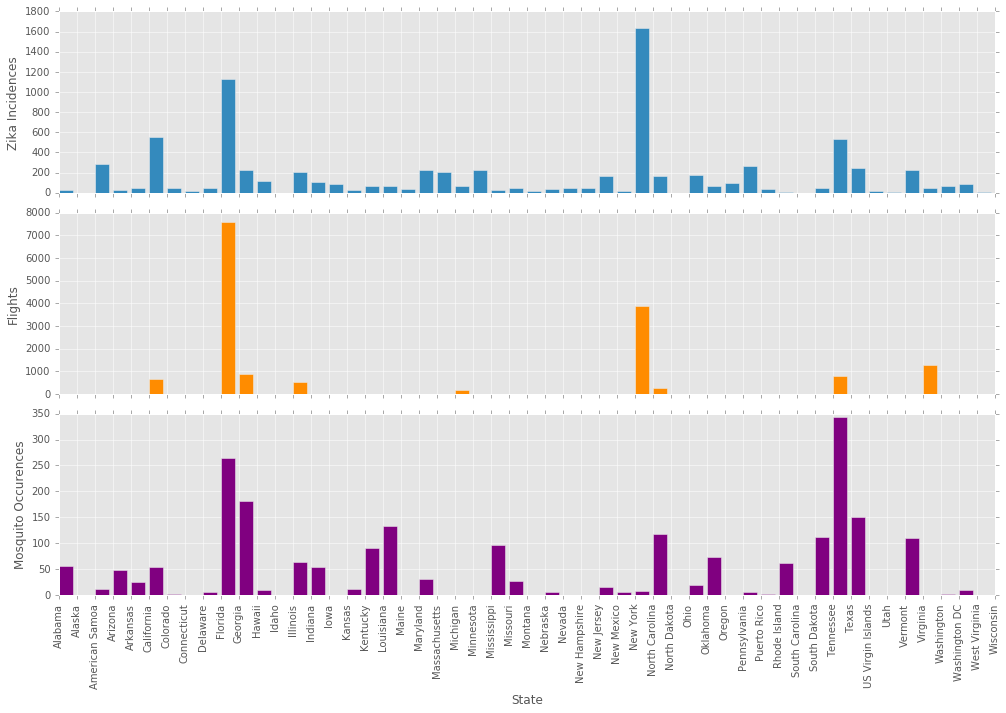

In [364]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14,10))
ind = np.arange(len(master_noPR))
ax1.bar(ind, master_noPR.zika_counts)
ax2.bar(ind, master_noPR.flights_oag, color='darkorange')
ax3.bar(ind, master_noPR.mosquito, color='purple')
ax2.set_ylabel('Flights')
ax1.set_ylabel('Zika Incidences')
ax3.set_ylabel('Mosquito Occurences')
ax3.set_xlabel('State')
labels = master.index
plt.xticks(ind,labels,rotation ='vertical')
#fig.suptitle('Zika Incidences, Flights, Mosquito Occurences by State', fontsize=20)
plt.tight_layout()
ax1.set_xlim(0,52)
#plt.show()

plt.savefig('subcharts.png', dpi=100)

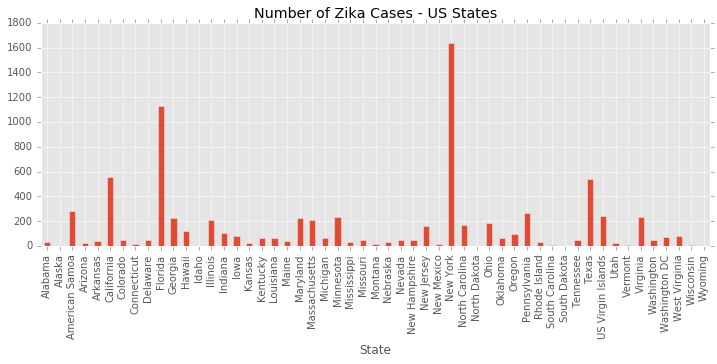

In [329]:
master_noPR = master.drop('Puerto Rico')
master_noPR.zika_counts.plot.bar(title = 'Number of Zika Cases - US States',figsize=(12,4), grid=True)
